<center><h1>Martinez_Ariel_Final_Project</h1></center>

Name: Ariel Martinez Birlanga
<br>
Github Username: ambirlanga
<br>
USC ID: 5483611649

## Project Packages

In [1]:
# TensorFlow and Keras 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Rescaling, Resizing, RandomCrop, RandomTranslation, RandomRotation, RandomZoom, RandomFlip, RandomContrast
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16, EfficientNetB0

# Sklearn 
from sklearn.metrics import classification_report, roc_auc_score

# Utility 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import logging
import warnings
tf.get_logger().setLevel(logging.ERROR) 
warnings.filterwarnings("ignore") 


## Data Exploration and Pre-processing

First we create all the dataset with a 20% cross validation split and one-hot encoding. We also stablish basic parameters like Image size and batch. Seed 42 is used for consistency.

In [2]:
# Data
train_dir =  '../Data/seg_train'
test_dir =  '..//Data/seg_test'

# Parameters
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 # Good balance

# Training dataset
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,  # Resize 
    batch_size=BATCH_SIZE,  # Batch 
    label_mode="categorical",  # One-hot encoding 
    validation_split=0.2,  # 20% validation
    subset="training",  # Subset
    seed=42  
)

# Validation dataset
val = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,  
    subset="validation",
    seed=42
)

# Test dataset
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical" 
)

print("")
classes = train.class_names
num_classes = len(classes)
print(f"Class names: {classes}")
print(f"Number of classes: {num_classes}")

print("\nOne-hot encoding Test")
for images, labels in train.take(1):  
    print("Sample:", labels[0]) 
    break


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.

Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6

One-hot encoding Test
Sample: tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)


## Data Augmentation

We apply sevelar augmentation techniques sequentialy (with Keras):
    
    Random cropping
    Random translation
    Random Rotation
    Random Flipping
    Brightness
    Random Contrast 
    Random Zoom


In [3]:
# Augmentation pipeline
pipeline = Sequential(
  [    
        # Croping gives considerably bad results
        #RandomCrop(height=200, width=200), # Crop and resize
        #Resizing(224, 224),    
        RandomFlip("horizontal"), # Flip H
        RandomRotation(factor=0.05), # Rotations 
        RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)), # Zoom 
        RandomTranslation(height_factor=0.1, width_factor=0.1), # Translations
        RandomContrast(factor=0.1), # Contrast 
        tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)), # Brightness
    ], 
    name = "pipeline",
)

## Transfer Learning

We create a function campable of creating a "Frozen" model for the 4 targeted types, 256 units, ReLU activation, L2 Regularization, Batch normalization, softmax output, and 20% dropout.

In [4]:
# Model creation

model_mapping = {
    "EfficientNetB0": EfficientNetB0,
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "ResNet101": ResNet101
}

def create_model(model_type, input_shape):
    inputs = Input(shape = input_shape)
    x = pipeline(inputs)
    basic_model = model_mapping[model_type](weights="imagenet", include_top=False, input_tensor = x)

    # Freeze 
    basic_model.trainable = False

    # Head
    x = GlobalAveragePooling2D(name = "avg_pool")(basic_model.output) 
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)    
    outputs = Dense(6, activation = "softmax", kernel_regularizer=l2(0.01))(x)
    return Model(inputs, outputs)


##  Model Training

We train the models using multinomial cross entropy as well as ADAM optimizer. Epoch = 100 as default. Use of learning rate scheduler. Early stopping at 10 instances without improvement,

In [5]:
def train_model(model, train_data, val_data, test_data, epochs, name, lr=0.001):
    
    # Learning rate scheduler
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6
    )
        
    # Set model
    model.compile(
        optimizer=Adam(lr), # ADAM
        loss="categorical_crossentropy", # Multinomial cross entropy
        metrics=["accuracy"]
    )

    # Model checkpoint callback
    #checkpoint_filepath = f'/kaggle/input/dsci-fp/final-project-ambirlanga/ModelCheckpoints/{name}.keras'
    #model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #    filepath=checkpoint_filepath,  
    #    monitor='val_loss', 
    #    save_best_only=True,  
    #    save_weights_only=False
    #)

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[lr_schedule, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] # Early stopping
    )

    return model, history

### ResNet50 Train

In [6]:
INPUT_SHAPE = (224, 224, 3)
models ={}
best ={}
histories ={}

print("Training ResNet50")
models["ResNet50"]  = create_model("ResNet50", INPUT_SHAPE)
best["ResNet50"], histories["ResNet50"]  = train_model(models["ResNet50"], train, val, test, 100, "ResNet50", 0.001)

Training ResNet50
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 177ms/step - accuracy: 0.7432 - loss: 0.8545 - val_accuracy: 0.8952 - val_loss: 0.3928 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8677 - loss: 0.4718 - val_accuracy: 0.9088 - val_loss: 0.3589 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8751 - loss: 0.4285 - val_accuracy: 0.9073 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8781 - loss: 0.4064 - val_accuracy: 0.8981 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8841 - loss: 0.3968 - val_accuracy: 0.9088 - val_loss: 0.3422 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8889 - loss: 0.3768 - val_accuracy: 0.9052 - val_loss: 0.3366 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 1

### ResNet101 Train

In [7]:
print("Training ResNet101")
models["ResNet101"]  = create_model("ResNet101", INPUT_SHAPE)
best["ResNet101"], histories["ResNet101"] = train_model(models["ResNet101"], train, val, test, 100, "ResNet101", 0.001)

Training ResNet101
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 283ms/step - accuracy: 0.7498 - loss: 0.8340 - val_accuracy: 0.8974 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 96s 273ms/step - accuracy: 0.8676 - loss: 0.4723 - val_accuracy: 0.9020 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 96s 272ms/step - accuracy: 0.8725 - loss: 0.4313 - val_accuracy: 0.9024 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 272ms/step - accuracy: 0.8854 - loss: 0.3968 - val_accuracy: 0.9020 - val_loss: 0.3521 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 96s 272ms/step - accuracy: 0.8807 - loss: 0.4032 - val_accuracy: 0.9070 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 272ms/step - accuracy: 0.8864 - loss: 0.3978 - val_accuracy: 0.9066 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s

### VGG16 Train

In [8]:
print("Training VGG16")
models["VGG16"] = create_model("VGG16", INPUT_SHAPE)
best["VGG16"], histories["VGG16"] = train_model(models["VGG16"], train, val, test, 100, "VGG16", 0.001)

Training VGG16
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.6131 - loss: 1.1763 - val_accuracy: 0.8621 - val_loss: 0.4884 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.8189 - loss: 0.5889 - val_accuracy: 0.8828 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.8424 - loss: 0.5049 - val_accuracy: 0.8917 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 203ms/step - accuracy: 0.8465 - loss: 0.4775 - val_accuracy: 0.8888 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.8562 - loss: 0.4658 - val_accuracy: 0.8938 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.8554 - loss: 0.4589 - val_accuracy: 0.8942 - val_loss: 0.3598 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201m

### EfficientNetB0 Train

In [9]:
print("Training EfficientNetB0:")
models["EfficientNetB0"] = create_model("EfficientNetB0", INPUT_SHAPE)
best["EfficientNetB0"], histories["EfficientNetB0"] = train_model(models["EfficientNetB0"], train, val, test, 100, "EfficientNetB0", 0.001)

Training EfficientNetB0:
Epoch 1/100


2024-12-14 14:34:22.516243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_8_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.7359 - loss: 0.8310 - val_accuracy: 0.9024 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.8622 - loss: 0.4550 - val_accuracy: 0.9120 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8810 - loss: 0.3908 - val_accuracy: 0.9056 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8826 - loss: 0.3747 - val_accuracy: 0.9145 - val_loss: 0.2891 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8876 - loss: 0.3637 - val_accuracy: 0.9113 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8874 - loss: 0.3517 - val_accuracy: 0.9138 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8925 - loss: 

# Evaluation

Scores for each model.

In [10]:
def eval_model(model, train_data, val_data, test_data, history):
    def calculate_metrics(model, dataset, name):
        predictions = []
        true_labels = []

        for x, y in dataset:
            probs = model.predict(x, verbose=0)  # Predicted probabilities
            predictions.extend(probs)  # Add probabilities
            true_labels.extend(y.numpy())  

        # Convert to NumPy arrays
        predictions = np.array(predictions)  
        true_labels = np.array(true_labels)  

        # Classification report 
        pred_labels = np.argmax(predictions, axis=-1)
        true_labels_argmax = np.argmax(true_labels, axis=-1)
        report = classification_report(true_labels_argmax, pred_labels, target_names=classes, output_dict=True)
        print(f"Metrics:\n", classification_report(true_labels_argmax, pred_labels, target_names=classes))

        # ROC AUC score 
        roc_auc = roc_auc_score(true_labels, predictions, multi_class="ovr", average="macro")
        print(f"ROC AUC Score: {roc_auc:.4f}")

        return report, roc_auc    


    # Plot training vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluate metrics for each dataset
    print("Evaluating Training Data...")
    train_report, train_auc = calculate_metrics(model, train_data, "Training")
    print("\nEvaluating Validation Data...")
    val_report, val_auc = calculate_metrics(model, val_data, "Validation")
    print("\nEvaluating Test Data...")
    test_report, test_auc = calculate_metrics(model, test_data, "Test")



    # Optionally return metrics if needed for further analysis
    return {
        "Train": {"report": train_report, "auc": train_auc},
        "Validation": {"report": val_report, "auc": val_auc},
        "Test": {"report": test_report, "auc": test_auc},
    }


Evaluation ResNet50:


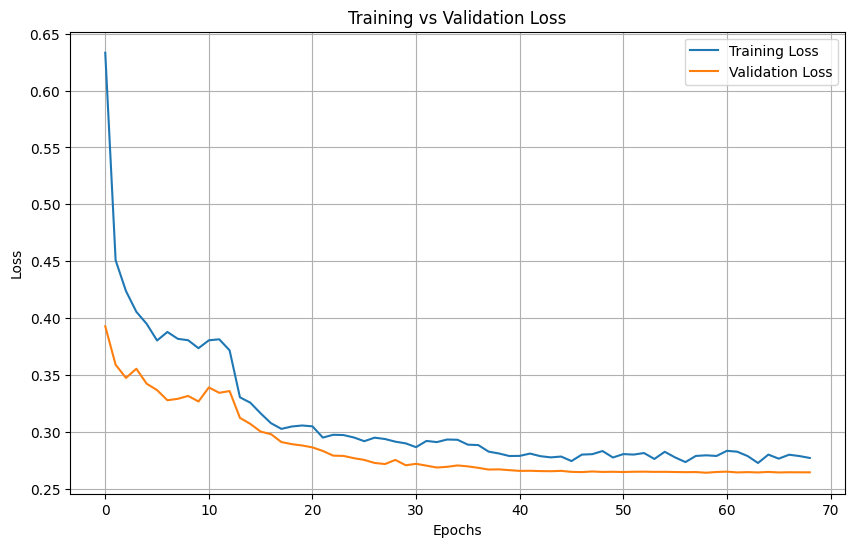

Evaluating Training Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.96      0.93      0.95      1761
      forest       0.99      0.99      0.99      1835
     glacier       0.92      0.87      0.89      1931
    mountain       0.89      0.91      0.90      1998
         sea       0.95      0.96      0.96      1797
      street       0.93      0.98      0.95      1906

    accuracy                           0.94     11228
   macro avg       0.94      0.94      0.94     11228
weighted avg       0.94      0.94      0.94     11228

ROC AUC Score: 0.9953

Evaluating Validation Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.95      0.92      0.93       430
      forest       0.99      1.00      0.99       436
     glacier       0.87      0.84      0.85       473
    mountain       0.86      0.87      0.86       514
         sea       0.95      0.94      0.95       477
      street       0.92      0.

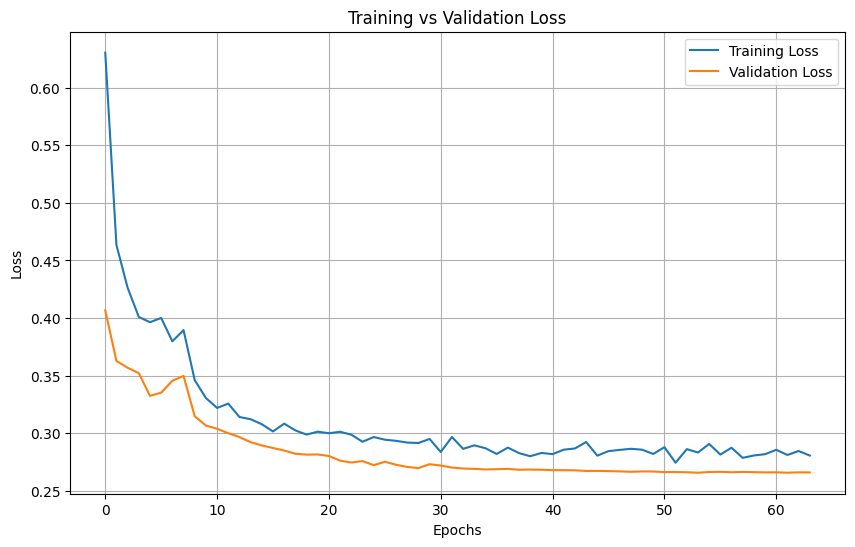

Evaluating Training Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.96      0.95      0.95      1761
      forest       0.99      0.99      0.99      1835
     glacier       0.91      0.87      0.89      1931
    mountain       0.89      0.89      0.89      1998
         sea       0.94      0.96      0.95      1797
      street       0.95      0.97      0.96      1906

    accuracy                           0.94     11228
   macro avg       0.94      0.94      0.94     11228
weighted avg       0.94      0.94      0.94     11228

ROC AUC Score: 0.9949

Evaluating Validation Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.94      0.95      0.94       430
      forest       0.99      1.00      0.99       436
     glacier       0.85      0.86      0.86       473
    mountain       0.89      0.86      0.88       514
         sea       0.94      0.95      0.95       477
      street       0.95      0.

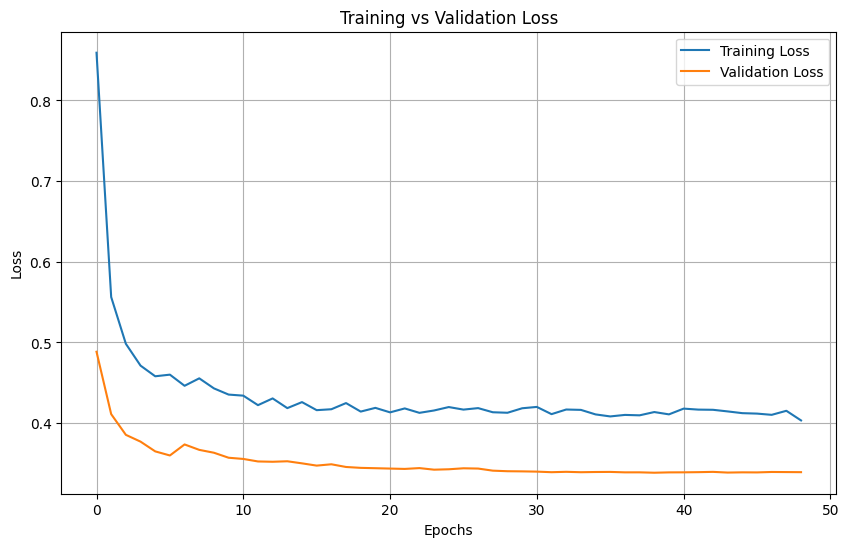

Evaluating Training Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.95      0.90      0.92      1761
      forest       0.99      0.98      0.99      1835
     glacier       0.83      0.84      0.83      1931
    mountain       0.85      0.82      0.83      1998
         sea       0.91      0.93      0.92      1797
      street       0.91      0.96      0.93      1906

    accuracy                           0.90     11228
   macro avg       0.91      0.91      0.90     11228
weighted avg       0.90      0.90      0.90     11228

ROC AUC Score: 0.9894

Evaluating Validation Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.95      0.90      0.93       430
      forest       1.00      1.00      1.00       436
     glacier       0.78      0.83      0.80       473
    mountain       0.86      0.79      0.82       514
         sea       0.91      0.92      0.92       477
      street       0.91      0.

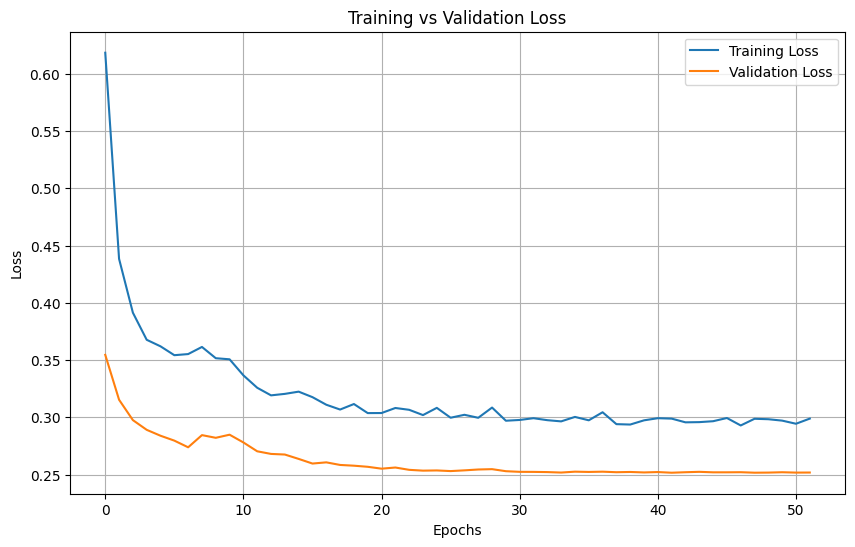

Evaluating Training Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.96      0.94      0.95      1761
      forest       0.99      0.99      0.99      1835
     glacier       0.88      0.85      0.87      1931
    mountain       0.88      0.87      0.88      1998
         sea       0.95      0.98      0.97      1797
      street       0.95      0.97      0.96      1906

    accuracy                           0.94     11228
   macro avg       0.94      0.94      0.94     11228
weighted avg       0.93      0.94      0.93     11228

ROC AUC Score: 0.9949

Evaluating Validation Data...
Metrics:
               precision    recall  f1-score   support

   buildings       0.93      0.94      0.94       430
      forest       0.98      1.00      0.99       436
     glacier       0.85      0.84      0.85       473
    mountain       0.89      0.85      0.87       514
         sea       0.94      0.97      0.95       477
      street       0.94      0.

In [11]:
metrics_summary = []
for model_type in  ["ResNet50","ResNet101","VGG16","EfficientNetB0"]:
    print(f"Evaluation {model_type}:")
    results = eval_model(best[model_type], train, val, test, histories[model_type])
    
     # Extract metrics for each dataset
    for dataset_name, metrics in results.items():
        report = metrics["report"]["weighted avg"]
        auc = metrics["auc"]
        
        # Append metrics to summary list
        metrics_summary.append({
            "Model": model_type,
            "Dataset": dataset_name,
            "Precision": report["precision"],
            "Recall": report["recall"],
            "F1 Score": report["f1-score"],
            "AUC": auc,
        })
    print("\n\n\n")
metrics_df = pd.DataFrame(metrics_summary)

In [12]:
# Display the DataFrame
metrics_df

,Model,Dataset,Precision,Recall,F1 Score,AUC
0,ResNet50,Train,0.940386,0.940239,0.940073,0.995286
1,ResNet50,Validation,0.920685,0.920527,0.920400,0.992159
2,ResNet50,Test,0.919797,0.919667,0.919351,0.992297
3,ResNet101,Train,0.936798,0.936943,0.936747,0.994876
4,ResNet101,Validation,0.925708,0.925873,0.925733,0.991998
5,ResNet101,Test,0.918632,0.919000,0.918455,0.992482
6,VGG16,Train,0.903721,0.903545,0.903345,0.989426
7,VGG16,Validation,0.897802,0.896650,0.896483,0.987321
8,VGG16,Test,0.889883,0.890000,0.889404,0.986831
9,EfficientNetB0,Train,0.934647,0.935073,0.934730,0.994887


## Observations

All of them have well pronounced curves and good metrics (like precision and accuracy), with only VGG16 being a slightly below the other. VGG16 was also slighlty faster to converge so maybe a different augmentation or option could improve its results slighltly.